In [240]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Linear
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
import torch_geometric as T
from torch_geometric.data.data import BaseData, Data
from torch_geometric.utils import from_networkx
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn import GCNConv, global_mean_pool, SAGEConv

import networkx as nx

from sklearn.metrics import roc_curve, auc

In [2]:
# Read from csvs without second list in daughter columns (30 s)
training_df = pd.read_csv('train_data.csv')
testing_df = pd.read_csv('test_data.csv')

In [383]:
# Duplicate Jet PT and Eta elements as a list the same length as the number of daughters in each row
def duplicate(df, cols, n_col):
    def duplicate_value(row, col, n_col):
        value = row[col]
        if isinstance(value, (float, int)):
            num_daughters = row[n_col]
            return [value] * num_daughters
        return value

    for col in cols:
        df[col] = df.apply(lambda row: duplicate_value(row, col, n_col), axis=1)
    return df

In [364]:
# Converts string into list of floats (already duplicated and dropped second array)
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [365]:
# Define features from daughter columns + overall kinematics (already duplicated)
train_d_cols = list(df[df.columns[df.columns.str.contains("_Daughters")]])
test_d_cols = list(df2[df2.columns[df2.columns.str.contains("_Daughters")]])

train_f_cols = train_d_cols + ['Jet0_Eta', 'Jet0_PT']
test_f_cols = test_d_cols + ['Jet1_Eta', 'Jet1_PT']

In [384]:
# Duplicate and preprocess daughter columns
df = duplicate(training_df, ['Jet0_PT', 'Jet0_Eta', 'IsB'], 'Jet0_nDaughters');
df2 = duplicate(testing_df, ['Jet1_PT', 'Jet1_Eta', 'IsB'], 'Jet1_nDaughters');

In [385]:
# Clean up data from str to list of floats (2 min)
convert_to_lists(df, train_d_cols);
convert_to_lists(df2, test_d_cols);

In [353]:
# Gets [num_nodes, num_features] to create tensor
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

# 3229537 Nodes, 31 Features, 27797017 Edges

In [435]:
# Gets node features to create x tensor
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

# Creates graphs for each node then sums
def create_data_object(df, features_cols):
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.float)
        train_mask = torch.ones(num_nodes, dtype=torch.bool)
        test_mask = torch.ones(num_nodes, dtype=torch.bool)

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
        data_list.append(data)
        
    combined_data = T.data.Batch.from_data_list(data_list)
    return combined_data

In [436]:
train_data = create_data_object(df, train_f_cols)

In [437]:
test_data = create_data_object(df2, test_f_cols)

In [570]:
# Load data - batch size of 32 is optimal
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [536]:
print('Training Data Attributes')
print(f'Number of nodes: {train_loader.dataset.num_nodes}')
print(f'Number of features: {train_loader.dataset.num_node_features}')
print(f'Number of edges: {train_loader.dataset.edge_index.shape[1]}')

Training Data Attributes
Number of nodes: 3229537
Number of features: 32
Number of edges: 27797017


In [537]:
print('Testing Data Attributes')
print(f'Number of nodes: {test_loader.dataset.num_nodes}')
print(f'Number of features: {test_loader.dataset.num_node_features}')
print(f'Number of edges: {test_loader.dataset.edge_index.shape[1]}')

Testing Data Attributes
Number of nodes: 2934654
Number of features: 32
Number of edges: 22533746


# Training Model

In [571]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(len(train_f_cols), 64)
        self.conv2 = SAGEConv(64, 64)
        self.conv3 = SAGEConv(64, 64)
        self.lin = torch.nn.Linear(64, 2)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = self.lin(x)

        return x

model = GNN()

In [572]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    return loss.item()

for epoch in range(2):
    loss = train(model, train_loader, optimizer, criterion)
    print(f'Epoch {epoch + 1}, Loss: {loss}')

def test(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            _, pred = out.max(dim=1)
            correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
            total_correct += correct
            total_samples += data.test_mask.sum().item()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = test(model, test_loader)
print(f'Accuracy: {accuracy}')

Epoch 1, Loss: 0.6926289200782776
Epoch 2, Loss: 0.6950892210006714
Accuracy: 0.49662754110024554


# ROC Curve and AUC

In [547]:
true_labels = [] # class values (0 or 1)
y_scores = [] # predicted probabilities

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        _, pred = out.max(dim=1)
        true_labels.append(data.y.numpy().flatten())
        y_scores.append(out[:, 1].detach().numpy())

true_labels = np.concatenate(true_labels)
y_scores = np.concatenate(y_scores)

In [548]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [549]:
# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

print(f'Background Rejection: {back_rej}')
print(f'Signal Efficiency: {sig_eff}')
print(f'AUC: {roc_auc}')

Background Rejection: [1.00000000e+00 9.99998646e-01 9.99998646e-01 ... 4.06167518e-06
 4.06167518e-06 0.00000000e+00]
Signal Efficiency: [0.00000000e+00 0.00000000e+00 2.05841649e-06 ... 9.99999314e-01
 1.00000000e+00 1.00000000e+00]
AUC: 0.501935722007925


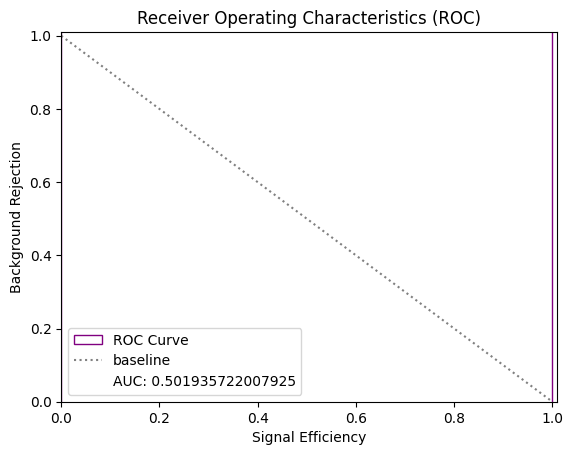

In [566]:
# Plot ROC Curve and show AUC
plt.hist(back_rej, label='ROC Curve', histtype='step', color='purple')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.plot([], [], ' ', label=f'AUC: {roc_auc}')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.show()